# 1.Enviroment

In [54]:
import os, shutil
import cv2
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2.Processing image data and corresponding annotation information

In [ ]:
training_anno = pd.read_csv('./seg_risky_training_anno.csv')


train_jpgs = []
for i in '0123456789abcdef':
    train_jpgs.extend([x.replace('./', '') for x in glob.glob(f'./{i}/*.jpg')])

training_anno = training_anno[training_anno['Path'].isin(train_jpgs)]
training_anno['Polygons'] = training_anno['Polygons'].apply(json.loads)

In [55]:
training_anno.head()

,Path,Polygons
0,9/9082eccbddd7077bc8288bdd7773d464.jpg,"[[[143, 359], [432, 359], [437, 423], [141, 42..."
1,9/960a20556624babe21991678dfad784e.jpg,"[[[173.0, 334.0], [248.0, 334.0], [248.0, 356...."
2,9/991cb7c5671c381634835beae58f0735.jpg,"[[[194, 53], [363, 63], [343, 425], [174, 415]]]"
3,5/5e018efb882f6223a882abfb6e77575e.jpg,"[[[112, 429], [251, 435], [249, 490], [110, 48..."
4,1/194a5027ed25dee1ad27a3f53a402f8c.jpg,"[[[70, 206], [383, 207], [383, 227], [70, 226]..."


In [56]:
training_anno.shape

(1020575, 2)

In [57]:
np.array(training_anno['Polygons'].iloc[4], dtype=np.int32)

array([[[ 70, 206],
        [383, 207],
        [383, 227],
        [ 70, 226]],

       [[ 72,  52],
        [237,  52],
        [237,  72],
        [ 72,  72]],

       [[ 71,  94],
        [429,  95],
        [429, 115],
        [ 71, 114]]], dtype=int32)

# 3.Draw the outline of the polygon provided in the comments on the image

(-0.5, 511.5, 511.5, -0.5)

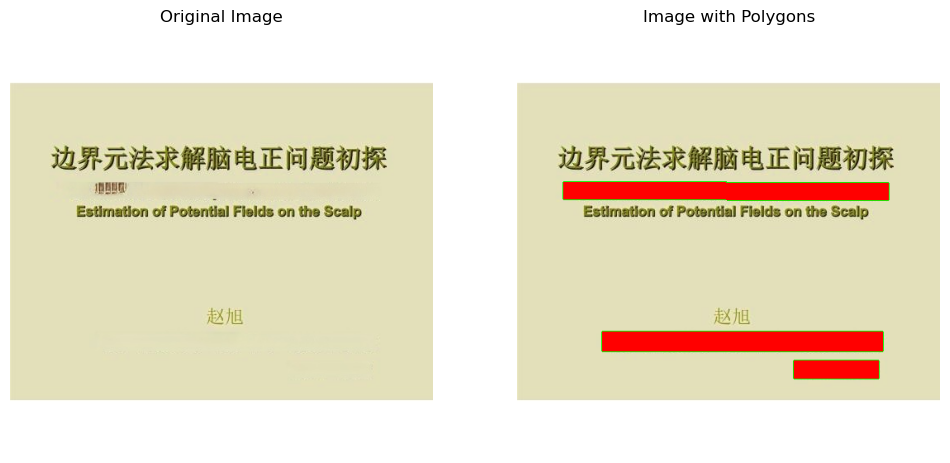

In [59]:
idx = 23
img = cv2.imread(training_anno['Path'].iloc[idx])

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(122)
img = cv2.imread(training_anno['Path'].iloc[idx])
polygon_coords = np.array(training_anno['Polygons'].iloc[idx], dtype=np.int32)

for polygon_coord in polygon_coords:
    cv2.polylines(img, np.expand_dims(polygon_coord, 0), isClosed=True, color=(0, 255, 0), thickness=2)
    img= cv2.fillPoly(img, np.expand_dims(polygon_coord, 0), color=(255, 0, 0, 0.5))

plt.imshow(img)
plt.title("Image with Polygons")
plt.axis('off')

# 4.Normalized processing

In [60]:
def normalize_polygon(polygon, img_width, img_height):
    return [(x / img_width, y / img_height) for x, y in polygon]

Use all training data for training

In [61]:
for row in training_anno.iterrows():
    shutil.copy(row[1].Path, 'yolo_seg_dataset/train')
    img = cv2.imread(row[1].Path)
    img_height, img_width = img.shape[:2]
    txt_filename = os.path.join('yolo_seg_dataset/train/' + row[1].Path.split('/')[-1][:-4] + '.txt')
    with open(txt_filename, 'w') as up:
        for polygon in row[1].Polygons:
            normalized_polygon = normalize_polygon(polygon, img_width, img_height)
            normalized_coords = ' '.join([f'{coord[0]:.3f} {coord[1]:.3f}' for coord in normalized_polygon])
            up.write(f'0 {normalized_coords}\n')

In [62]:
for row in training_anno.iloc[10000:10150].iterrows():
    shutil.copy(row[1].Path, 'yolo_seg_dataset/valid')

    img = cv2.imread(row[1].Path)
    img_height, img_width = img.shape[:2]
    txt_filename = os.path.join('yolo_seg_dataset/valid/' + row[1].Path.split('/')[-1][:-4] + '.txt')
    with open(txt_filename, 'w') as up:
        for polygon in row[1].Polygons:
            normalized_polygon = normalize_polygon(polygon, img_width, img_height)
            normalized_coords = ' '.join([f'{coord[0]:.3f} {coord[1]:.3f}' for coord in normalized_polygon])
            up.write(f'0 {normalized_coords}\n')

# 5.Configuration file

In [63]:
with open('yolo_seg_dataset/data.yaml', 'w') as up:
    data_root = os.path.abspath('yolo_seg_dataset/')
    up.write(f'''
path: {data_root}
train: train
val: valid

names:
    0: alter
''')

In [7]:
# !mkdir -p /root/.config/Ultralytics/
# !wget http://mirror.coggle.club/yolo/Arial.ttf -O /root/.config/Ultralytics/Arial.ttf
# !wget http://mirror.coggle.club/yolo/yolov8n-v8.2.0.pt -O yolov8n.pt
#!wget http://mirror.coggle.club/yolo/yolov8n-seg-v8.2.0.pt -O yolov8n-seg.pt
# !wget http://mirror.coggle.club/yolo/yolov11n-seg-v8.2.0.pt -O yolov11n-seg.pt

--2024-10-12 16:14:53--  http://mirror.coggle.club/yolo/yolov8n-seg-v8.2.0.pt
Resolving mirror.coggle.club (mirror.coggle.club)... 163.181.81.234, 163.181.81.235, 163.181.81.236, ...
Connecting to mirror.coggle.club (mirror.coggle.club)|163.181.81.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7071756 (6.7M) [application/vnd.snesdev-page-table]
Saving to: ‘yolov8n-seg.pt’

yolov8n-seg.pt      100%[===================>]   6.74M  10.6MB/s    in 0.6s    

2024-10-12 16:14:53 (10.6 MB/s) - ‘yolov8n-seg.pt’ saved [7071756/7071756]



# 6.Train the YOLO model

1.batch size 
the number of training samples processed simultaneously in each training iteration
Turn up the batch
2.Increase the number of training sessions

In [1]:
from ultralytics import YOLO

model = YOLO("/root/dw_AI_defense_track2/yolo11n-seg.pt")  
results = model.train(data="/root/dw_AI_defense_track2/yolo_seg_dataset/data.yaml", epochs=1, imgsz=512,batch=4, workers=4,save_period=1)

New https://pypi.org/project/ultralytics/8.3.11 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.10 🚀 Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine/trainer: task=segment, mode=train, model=/root/dw_AI_defense_track2/yolo11n-seg.pt, data=/root/dw_AI_defense_track2/yolo_seg_dataset/data.yaml, epochs=1, time=None, patience=100, batch=4, imgsz=512, save=True, save_period=1, cache=False, device=None, workers=4, project=None, name=train21, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

train: Scanning /root/dw_AI_defense_track2/yolo_seg_dataset/train.cache... 1020575 images, 0 backgrounds, 238 corrupt: 100%|██████████| 1020575/1020575 [00:00<?, ?it/s]

train: WARNING ⚠️ /root/dw_AI_defense_track2/yolo_seg_dataset/train/00738a265eff3a4a47af81fc7035bfa5.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.221       1.012]
train: WARNING ⚠️ /root/dw_AI_defense_track2/yolo_seg_dataset/train/00ec0e9dfb68e706a1bd059949073112.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.023]
train: WARNING ⚠️ /root/dw_AI_defense_track2/yolo_seg_dataset/train/033c9b3f421abbee6213c381f5b16092.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.028]
train: WARNING ⚠️ /root/dw_AI_defense_track2/yolo_seg_dataset/train/036f9c42ccb5342307995f88171f956f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.004]
train: WARNING ⚠️ /root/dw_AI_defense_track2/yolo_seg_dataset/train/03a26fcbd2f13b33b63becea41766b01.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]
train: WARNING ⚠️ 


val: Scanning /root/dw_AI_defense_track2/yolo_seg_dataset/valid.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]


Plotting labels to runs/segment/train21/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to runs/segment/train21
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/1     0.608G      1.448      1.442      1.823      1.198          3        512: 100%|██████████| 255085/255085 [5:55:56<00:00, 11.94it/s]      
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.25it/s]


                   all        150        223      0.845      0.668      0.764      0.554      0.849       0.68      0.746      0.468

1 epochs completed in 5.934 hours.
Optimizer stripped from runs/segment/train21/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train21/weights/best.pt, 6.0MB

Validating runs/segment/train21/weights/best.pt...
Ultralytics 8.3.10 🚀 Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 12.48it/s]


                   all        150        223      0.847      0.668      0.763      0.554      0.849       0.68      0.747      0.467
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train21


# 7.Processing test image

In [ ]:
from ultralytics import YOLO

model = YOLO("./runs/segment/train21/weights/best.pt")  
results = model.train(data="/root/dw_AI_defense_track2/yolo_seg_dataset/data.yaml", epochs=1, imgsz=512,batch=4, workers=4,save_period=1)

In [11]:
from ultralytics import YOLO
import glob
from tqdm import tqdm

model = YOLO("./runs/segment/train21/weights/best.pt")  

test_imgs = glob.glob('./testing_data/test_set_A_rename/*/*')

In [12]:
print(test_imgs[:5])

['./testing_data/test_set_A_rename/1/12e6885ab2a4a92cd7f0d75f13076de8.jpg', './testing_data/test_set_A_rename/1/1a55aff7437e3801e524f7d3ef321bf7.jpg', './testing_data/test_set_A_rename/1/14c34d72c723d5be3738a0ea9b2ef266.jpg', './testing_data/test_set_A_rename/1/1da7dc034f0c16429f84db27b1c2c44d.jpg', './testing_data/test_set_A_rename/1/188858a3ec7c0c3398dd294a177577a0.jpg']


# 8.Get segmentation results for each image

In [23]:
Polygon = []
for path in tqdm(test_imgs[:5]):
    results = model(path, verbose=False)
    result = results[0]
    if result.masks is None:
        Polygon.append([])
    else:
        print([mask.tolist() for mask in result.masks.xy])

100%|██████████| 5/5 [00:00<00:00, 15.51it/s]

[[[198.3828125, 29.5390625], [198.3828125, 47.41796875], [266.01171875, 47.41796875], [266.01171875, 29.5390625]]]
[[[403.0, 2.0], [403.0, 65.0], [426.0, 65.0], [426.0, 3.0], [420.0, 3.0], [419.0, 2.0]]]
[[[16.875, 151.87498474121094], [16.875, 229.68748474121094], [127.49999237060547, 229.68748474121094], [127.49999237060547, 181.87498474121094], [128.4375, 180.93748474121094], [128.4375, 156.56248474121094], [129.375, 155.62498474121094], [132.1875, 155.62498474121094], [132.1875, 151.87498474121094]], [[110.62499237060547, 451.8749694824219], [110.62499237060547, 469.6874694824219], [267.1875, 469.6874694824219], [267.1875, 451.8749694824219]]]


Use the model to predict all data

In [27]:
import cv2
import numpy as np
from tqdm import tqdm

Polygon = []
for path in tqdm(test_imgs):
    results = model(path, verbose=False)
    result = results[0]
    if result.masks is None:
        Polygon.append([])
    else:
        rects = []
        for mask in result.masks.xy:
            # Convert mask coordinates to a numpy array of type int
            contour = np.array(mask, dtype=np.int32)
            # Get the bounding rectangle for the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Calculate the four vertices of the rectangle
            rect = [[x, y], [x, y + h], [x + w, y + h], [x + w, y]]
            rects.append(rect)
        Polygon.append(rects)

100%|██████████| 100000/100000 [18:46<00:00, 88.78it/s] 


# 9.Create a submission

In [28]:
import pandas as pd
submit = pd.DataFrame({
    'Path': [x.split('/')[-1] for x in test_imgs],
    'Polygon': Polygon
})

submit = pd.merge(submit, pd.DataFrame({'Path': [x.split('/')[-1] for x in test_imgs[:]]}), on='Path', how='right')

submit = submit.fillna('[]')

submit.to_csv('track2_submit.csv', index=None)